Hello lev,
Following our talk, please see the task below.
We would love to get an answer within a week~
If you have any questions, please feel free to contact Oded/Pavel CC'd to this email.
Good luck!
Some background:
In driver monitoring system face detection is critical block in pipeline, because without proper face detection all following algorithms will fail.
Accurate face detection algorithms are slow, so to produce real time application, we use fast trackers to track found faces.
Trackers are fast but they can loose face and track another objects. To validate that tracker tracks valid face, we need fast classifier that will decide if tracker result is valid face. Valid face is face aligned face, shifted faces considered to be invalid (because other blocks in the pipeline, expect aligned faces).

Task:
You need to design and implement such system (face validator) based on Neural Networks. We prefer implementation using Keras APIs, but if you unfamiliar with Keras or have difficulties working with it, you can use tensorflow (preferred)  or any other framework for training/test neural networks.

We provide you with dataset (small part of big dataset) of valid (aligned) faces and negatives (not faces or not aligned faces).
Your implementation should be fast. Guideline real time (less then 30ms) on i7 CPU without GPU.
If you have weak CPU and it is hard to you to estimate run time on i7 CPU, lets say it should be less than 300ms on your system. It is only guideline (there is no strict limit or specific number). We will test your network with another images from the same dataset (images that were not provided to you) to test your network.

You can build your own network from the scratch or use existing classification networks or parts of them.

You should be able to describe you design process and decisions that was taken in choosing architecture and training the network. This is the most important part of the task and not the final result itself (final achieved accuracy and run time performance).


In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import numpy as np

import os 
import random

import csv

import datetime
import cv2
import timeit

import pandas as pd

import pickle as pkl

import mtcnn

import cvlib


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [2]:
# globals..
#for initial experiments and manipulations
pos_path='as_received_data\\aligned'
neg_path='as_received_data\\negative'

# for model cells and onwards
Neg_Dir= 'data\\negative'
Pos_Dir= 'data\\aligned'  
Models_Dir= 'preTrainedModels'

Wrong_Dir='wrongPrediction'

Results_Dir= 'results'
Results_File_Path= Results_Dir+'\\'+'results.csv'

Results_head=["comment","model_comment","date_time","batch",
             "learning_rate","epochs","time_ms","accuracy","recall"]

In [80]:
# functions
def get_rand_img_paths(path,n=10):
    """
    @param: path  path to a folder with images (no validation)
    @param: n     number of random paths
    
    Return:       "n" random paths from "path"
    """
    paths=[]
    for i in range(0,n):
        rand_file_path= random.choice(os.listdir(path))
        file_path = path+'\\'+ rand_file_path
        paths.append(file_path)

    return paths

def show_pos_neg_random(amount=5):
    """
    @param: amount  amount of images to display in each row
    
    Return: shows 2 rows. upper- positive aligned faces, bottom- not aligned faces.
            each row at the length of "amount"
    """
    pos_path_list= get_rand_img_paths(pos_path,amount)
    neg_path_list= get_rand_img_paths(neg_path,amount)
    assert len(pos_path_list)==len(neg_path_list)

    images_pos = [PIL.Image.open(path).convert("L") for path in pos_path_list ]
    np_images_pos = [ np.asarray(im) for im in images_pos ]

    images_neg = [PIL.Image.open(path).convert("L") for path in neg_path_list ]
    np_images_neg = [ np.asarray(im) for im in images_neg ]

    n_rows=2
    n_cols= len(pos_path_list)


    fig, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False,figsize=(10, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)
    for row in range(0,n_rows):
        for col in range(0,n_cols):
            axarr[row][col].axis('off')  # Turn off tick labels
            if row==0:
                axarr[row][col].imshow(np_images_pos[col], cmap='gray', vmin=0, vmax=255) #keep same image colors
            else:
                axarr[row][col].imshow(np_images_neg[col], cmap='gray', vmin=0, vmax=255) #keep same image colors

def show_random(path, amount=5):
    """
    @param: amount  amount of images to display
    
    Return: shows random images  at the length of "amount" from "path"
    """
    path_list= get_rand_img_paths(path,amount)

    images = [PIL.Image.open(path).convert("L") for path in path_list ]
    np_images = [ np.asarray(im) for im in images ]


    n_cols= len(path_list)


    fig, axarr = plt.subplots(ncols=n_cols, squeeze=False,figsize=(10, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)
    for col in range(0,n_cols):
        axarr[0][col].axis('off')  # Turn off tick labels
        axarr[0][col].imshow(np_images[col], cmap='gray', vmin=0, vmax=255) #keep same image colors

def imageCropResize(in_image, percent=80, dest_size=50):
    """
    @param: in_image   PIL already opened image
    @param: percent    how much percent to leave in image
    @param: dest_size  desired pixel size 
    
    note: Currently assuming a desired square sizes.
    
    Return: 
    """
    width, height = in_image.size   # Get dimensions

    desired_percent_width= percent
    desired_percent_height= percent

    new_width= int(width * desired_percent_width / 100)
    new_height= int(height * desired_percent_height / 100)

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im_raw_centered = in_image.crop((left, top, right, bottom))
    im_raw_centered_resized=im_raw_centered.resize((dest_size, dest_size), resample=PIL.Image.LANCZOS)
    return im_raw_centered_resized  


def cropResizeSave():
    """
    this function was used once in order to transform newly imported images to the same dimensions
    and format as the aligned faces I have received for this task
    """
    # cropping and centering each image
    percent= 80
    dest_size= 50 # same for height and width
    dest_folder_path='raw_cropped_centered'
    raw_folder_path= 'raw_imported_positives'

    for img_path in os.listdir(raw_folder_path):
        im_raw= PIL.Image.open(raw_folder_path+'//'+img_path)
        adjusted= imageCropResize(im_raw,percent,dest_size)
        image_name= os.path.splitext(img_path)[0]
        adjusted.save(dest_folder_path+'//'+image_name+'.png',"PNG")
        

def add_result(info):
    """
    @param: info   list object with 9 cells: 
                    #comment	model_comment	date_time
                    batch	    learning_rate	epochs
                    time_miliseconds	accuracy	recall
    Result: writes the result for this model, to a new row in my results CSV file
    """
    assert len(info) == len(Results_head)

    #  save to csv (append new lines)
    file = open(Results_File_Path, 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(info)        
        
        
        
def show_random_from_list(in_list, amount=5):
    """
    @param: amount    amount of images to display
    @param: in_list   list
    
    Return: shows random images  at the length of "amount" from a certain list
    """
    assert in_list!=None
    if amount==0:
        return
    elif amount > len(in_list):
        amount= len(in_list)
    
    path_list= random.sample(in_list,k=amount)

    images = [PIL.Image.open(path).convert("L") for path in path_list ]
    np_images = [ np.asarray(im) for im in images ]


    n_cols= len(path_list)


    fig, axarr = plt.subplots(ncols=n_cols, squeeze=False,figsize=(10, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)
    for col in range(0,n_cols):
        axarr[0][col].axis('off')  # Turn off tick labels
        axarr[0][col].imshow(np_images[col], cmap='gray', vmin=0, vmax=255) #keep same image colors

        
        
def cv_model_scale_neighbors(scale=1,minNeighbors=3):
    """
    modifying scale and minNeighbors to see how it effects the results
        
    """
    model_path= Models_Dir + '//' + 'haarcascade_frontalface_default.xml'
    classifier = cv2.CascadeClassifier(model_path)
    
    now_time_date = datetime.datetime.now()
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n cv2.CascadeClassifier(haarcascade_frontalface_default.xml)\nscale_{scale} MinNeighbors_{minNeighbors}',
              curr_time_date, "-","-","-"]     

    timings=[]
    pos_correct=0  
    neg_correct=0
    
    #check negatives
    for image_path in os.listdir(Neg_Dir):
        neg_image_path= Neg_Dir + '\\' + image_path
        pixels = cv2.imread(neg_image_path)
        if scale==1:
            start = int(timeit.time.time() * 1000)
            bboxes = classifier.detectMultiScale(pixels,minNeighbors=minNeighbors)
            end= int(timeit.time.time() * 1000)
            timings.append( end - start )
        else:
            start = int(timeit.time.time() * 1000)
            bboxes = classifier.detectMultiScale(pixels,scale,minNeighbors)
            end= int(timeit.time.time() * 1000)
            timings.append( end - start )
        if len(bboxes)==0:
            neg_correct+=1
    
    #check positives
    for image_path in os.listdir(Pos_Dir):
        pos_image_path= Pos_Dir + '\\' + image_path
        pixels = cv2.imread(pos_image_path)
        if scale==1:
            start = int(timeit.time.time() * 1000)
            bboxes = classifier.detectMultiScale(pixels,minNeighbors=minNeighbors)
            end= int(timeit.time.time() * 1000)
            timings.append( end - start )
        else:
            start = int(timeit.time.time() * 1000)
            bboxes = classifier.detectMultiScale(pixels,scale,minNeighbors)
            end= int(timeit.time.time() * 1000)
            timings.append( end - start )

        if len(bboxes) == 1:
            pos_correct+=1

    avg_pred_time= sum(timings)/len(timings)

    res_line.append(avg_pred_time)

    total= len(os.listdir(Neg_Dir)) + len(os.listdir(Pos_Dir))
    total_correct= neg_correct + pos_correct
    accuracy= total_correct * 100 / total

    res_line.append(accuracy)

    recall= pos_correct * 100 / len(os.listdir(Pos_Dir))
    res_line.append(recall)
    add_result(res_line)
    
    
# gather stats
def append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct ):
    """
    @param: res_line list object to append stats
    @param: timings  list with timings for predictions
    @param: Neg_Dir  negatives dir path with images
    @param: Pos_Dir  positives dir path with images
    @param: neg_correct  number of correct predictions for negatives
    @param: pos_correct  number of correct predictions for positives
    
    Note that res_line should already exsit!
    """
    assert res_line != None
    
    avg_pred_time= sum(timings)/len(timings)
    res_line.append(avg_pred_time)
    total= len(os.listdir(Neg_Dir)) + len(os.listdir(Pos_Dir))
    total_correct= neg_correct + pos_correct
    accuracy= total_correct * 100 / total
    res_line.append(accuracy)
    recall= pos_correct * 100 / len(os.listdir(Pos_Dir))
    res_line.append(recall)    
    
    
def save_Falses(Wrong_Dir,model_name,false_predictions):
    save_path= Wrong_Dir + '//' + model_name
    with open(save_path, 'wb') as handle:
        pkl.dump(false_predictions, handle)    
        
        
        
def test_mcnn(scale=0.709):
    now_time_date = datetime.datetime.now()
    model=mtcnn.MTCNN(scale_factor=scale)
    model_name= f'mtcnn_scale_{scale}'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    pos_correct=0  
    neg_correct=0

    for image_path in os.listdir(Neg_Dir):
        neg_image_path= Neg_Dir + '\\' + image_path

        image = PIL.Image.open(neg_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        faces = model.detect_faces(pixels)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)!=0:
            false_predictions.append(neg_image_path)
        else:
            neg_correct+=1    

    for image_path in os.listdir(Pos_Dir):
        pos_image_path= Pos_Dir + '\\' + image_path

        image = PIL.Image.open(pos_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        faces = model.detect_faces(pixels)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)==0:
            false_predictions.append(pos_image_path)
        else:
            pos_correct+=1
        
        
    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    #return list(false_predictions)
    show_random_from_list(false_predictions,amount=5)        
    
    
    

# load and prepare an image
def load_image_pixels(filename, shape):
    """
    edited from open-source
    """
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = np.expand_dims(image, 0)
    return image, width, height

def test_YOLOv3():
    now_time_date = datetime.datetime.now()
    model = load_model(Models_Dir +'//'+ 'yoloV3.h5')
    input_w, input_h = 416, 416
    
    model_name= f'YOLOv3'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    pos_correct=0  
    neg_correct=0

    keep_track=0
    # TODO could make a functions instead of 2 for loops..
    for image_path in os.listdir(Neg_Dir):
        keep_track+=1
        if keep_track % 25 == 0:
            print(keep_track, end=' ')
        
        neg_image_path= Neg_Dir + '\\' + image_path

        image, image_w, image_h = load_image_pixels(neg_image_path, (input_w, input_h))

        start = int(timeit.time.time() * 1000)
        faces = model.predict(image)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)!=0:
            false_predictions.append(neg_image_path)
        else:
            neg_correct+=1    

    for image_path in os.listdir(Pos_Dir):
        keep_track+=1
        if keep_track % 25 == 0:
            print(keep_track, end=' ')
        
        pos_image_path= Pos_Dir + '\\' + image_path

        image, image_w, image_h = load_image_pixels(pos_image_path, (input_w, input_h))

        start = int(timeit.time.time() * 1000)
        faces = model.predict(image)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)==0:
            false_predictions.append(pos_image_path)
        else:
            pos_correct+=1
        
        
    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    #return list(false_predictions)
    show_random_from_list(false_predictions,amount=5)     

In [4]:
# candidate models
class Model_cv2_haarcascade():
    def __init__(self,in_scale= 1.02, in_minNeighbors= 4):
        """
        assuming you have the same folder and file I had. you can modify it if not.
        
        you can download the used model from:
        https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
        """
        self.Models_Dir= 'preTrainedModels'
        self.model_path= Models_Dir + '//' + 'haarcascade_frontalface_default.xml'
        self.classifier = cv2.CascadeClassifier(self.model_path)
        
        self.dest_size= 50
        self.scale= in_scale
        self.minNeighbors= in_minNeighbors
        
    def transform_predict(self, image):
        """
        @param: image    an already "imread" image
        
        Result:  True if faces are found, False otherwise. (about 5 millisecond run time)
        
        the function turns the image to greyscale and reshapes to a (50,50) size
        which was the size I tested the model and parameters upon.
        
        usage example: 
            model= Model_cv2_haarcascade()
            image = cv2.imread("Rudolf_Schuster_0001.jpg")
            model.transform_predict(image)
            
        
        """
        grey= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        resized= cv2.resize(grey,(dest_size,dest_size),interpolation =cv2.INTER_AREA)
        bboxes = self.classifier.detectMultiScale(resized,self.scale,self.minNeighbors)
        if len(bboxes)>0:
            return True
        else:
            return False
    
    
    

# exploring dataset

I would like to verify the problem statement in relate to the dataset.
at first glance it seemed "an aligned face" is a face you see entirely in an image.
I want to verify because you can still see an entire face but the face can be "shifted"- looking to a certain direction.

(50, 50) L


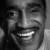

In [44]:
im0= PIL.Image.open('as_received_data\\aligned\\000298.jpg_0_3431439_.png')
print(im0.size, im0.mode)
im0


In [101]:
# pos_paths=[]
# def get_rand_img_paths(path,n=10):
#     paths=[]
#     for i in range(0,10):
#         rand_file_path= random.choice(os.listdir(path))
#         file_path = path+'\\'+ rand_file_path
#         paths.append(file_path)

#     return paths

In [58]:
image = PIL.Image.open(pos_paths[0]).convert("L")
arr = np.asarray(image)
arr #understand structure

array([[ 84, 107, 120, ...,  26,  21,  25],
       [ 74,  95, 107, ...,  23,  22,  25],
       [ 63,  79,  93, ...,  23,  25,  30],
       ...,
       [192, 236, 231, ...,  88,  79,  78],
       [204, 236, 230, ..., 107,  99,  97],
       [185, 235, 230, ..., 136, 126, 124]], dtype=uint8)

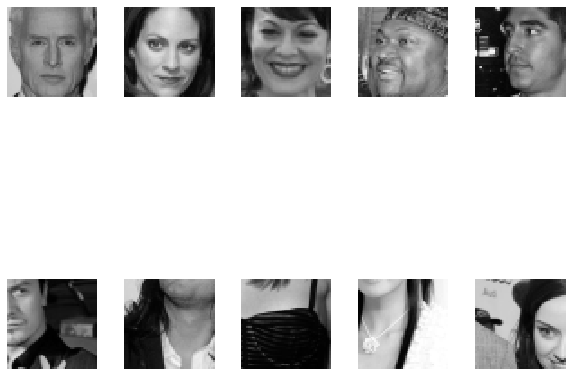

In [163]:
pos_path_list= get_rand_img_paths(pos_path,5)
neg_path_list= get_rand_img_paths(neg_path,5)
assert len(pos_path_list)==len(neg_path_list)

images_pos = [PIL.Image.open(path).convert("L") for path in pos_path_list ]
np_images_pos = [ np.asarray(im) for im in images_pos ]

images_neg = [PIL.Image.open(path).convert("L") for path in neg_path_list ]
np_images_neg = [ np.asarray(im) for im in images_neg ]

n_rows=2
n_cols= len(pos_path_list)


fig, axarr = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False,figsize=(10, 10))
fig.subplots_adjust(wspace=0.3, hspace=0)
for row in range(0,n_rows):
    for col in range(0,n_cols):
        axarr[row][col].axis('off')  # Turn off tick labels
        if row==0:
            axarr[row][col].imshow(np_images_pos[col], cmap='gray', vmin=0, vmax=255) #keep same image colors
        else:
            axarr[row][col].imshow(np_images_neg[col], cmap='gray', vmin=0, vmax=255) #keep same image colors


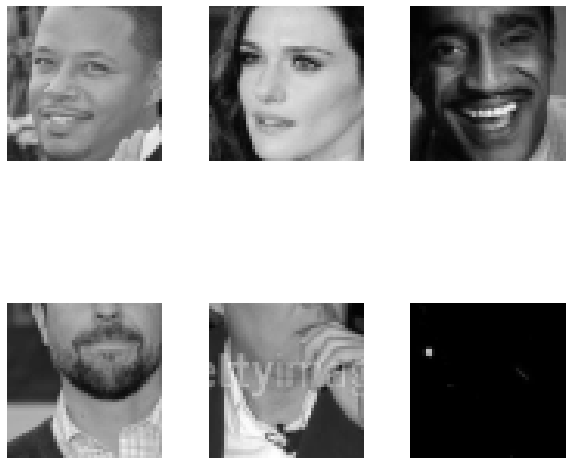

In [44]:
show_pos_neg_random(3)

In [ ]:
# someone has an interesting sense of humor according to the negative set...

In [181]:
# check number wise the dataset:
print(f'positive images: {len(os.listdir(pos_path))}')
print(f'negative images: {len(os.listdir(neg_path))}')
print(f'ratio pos:neg 1:{int(len(os.listdir(neg_path))*(1/len(os.listdir(pos_path))))}')

positive images: 147
negative images: 1248
ratio pos:neg 1:8


In [185]:
print(f'want to add {len(os.listdir(neg_path)) - len(os.listdir(pos_path))} positive images')

want to add 1101 positive images


In [187]:
raw_path= 'raw_imported_positives'
print(f'imported: {len(os.listdir(raw_path))} images')

imported: 1101 images


(250, 250) L


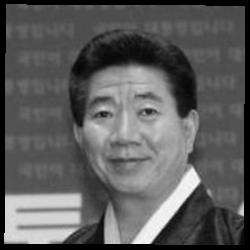

In [189]:
im_raw= PIL.Image.open(raw_path+'//'+'Roh_Moo-hyun_0024.jpg')
print(im_raw.size, im_raw.mode)
im_raw

(50, 50) L


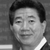

In [215]:
#check function:
res= imageCropResize(im_raw)
dest_path='raw_cropped_centered'
image_name='Roh_Moo-hyun_0024'
im_raw_centered_resized.save(dest_path+'//'+image_name+'.png',"PNG")

check= PIL.Image.open(dest_path+'//'+image_name+'.png')
print(check.size, check.mode)
check

In [218]:
cropResizeSave() #one time used func. read docstring

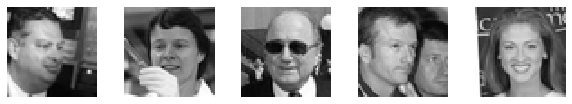

In [278]:
#  verified all at desired size..let's look randomely just to verify everything as expected
show_random(dest_folder_path)

In [288]:
#verifying myself - sort of unit test..
neg_folder= 'data\\negative'
for img_path in os.listdir(neg_folder):
    img= PIL.Image.open(neg_folder+'//'+img_path)
    assert img.mode == "L"
    assert img.size[0]==50
    assert img.size[1]==50

pos_folder= 'data\\aligned'    
for img_path in os.listdir(pos_folder):
    img= PIL.Image.open(pos_folder+'//'+img_path)
    assert img.mode == "L"
    assert img.size[0]==50
    assert img.size[1]==50   
assert (len(os.listdir(neg_folder)) - len(os.listdir(pos_folder)))==0
print("all images are in greyscale format, with (50,50) size, and we have 1:1 ratio")

all images are in greyscale format, with (50,50) size, and we have 1:1 ratio


(50, 50) L


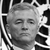

In [284]:
# why are there 3 kb images also? 
im_3kb= PIL.Image.open(pos_dest_folder_path+'//'+'Sergio_Vieira_De_Mello_0008.png')
print(im_3kb.size, im_3kb.mode)
im_3kb

## after acheving a 1:1 ratio, I'll move forward to build a simple working network, and decide upon parameters to compare between models

In [84]:
Results_Dir= 'results'
Results_File_Path= Results_Dir+'\\'+'results.csv'
Results_head=["comment","model_comment","date_time","batch",
             "learning_rate","epochs","time_ms","accuracy","recall"]


In [301]:
# # info=["sdf sdfas","sdfsd dsfd","23/9/4 23:54:66",0.45,44,4,3,6,8]
# # add_result(info)
# def add_result(info):
#     """
#     @param: info   list object with 9 cells: 
#                     #comment	model_comment	date_time
#                     batch	    learning_rate	epochs
#                     time_miliseconds	accuracy	recall
#     Result: writes the result for this model, to a new row in my results CSV file
#     """
#     assert len(info) == len(Results_head)

#     #  save to csv (append new lines)
#     file = open(Results_File_Path, 'a', newline='')
#     with file:
#         writer = csv.writer(file)
#         writer.writerow(info)

after I've decided on an initial way to compare future models, I'm starting to explore existing real time solutions for fast face detection. I'm looking for aligned faces only, but I think this would be a good start.

In [49]:
# load the pre-trained model
model_path= Models_Dir + '//' + 'haarcascade_frontalface_default.xml'
classifier = cv2.CascadeClassifier(model_path)

In [10]:
# load the photograph
image_path= Pos_Dir + '//' + random.choice(os.listdir(Pos_Dir))
neg_image_path= Neg_Dir + '//' + random.choice(os.listdir(Neg_Dir))

next cell is an initial experiment with cv2.

In [21]:
# load the photograph
image_path= Pos_Dir + '//' + random.choice(os.listdir(Pos_Dir))
neg_image_path= Neg_Dir + '//' + random.choice(os.listdir(Neg_Dir))

pixels = cv2.imread(neg_image_path)
# perform face detection
bboxes = classifier.detectMultiScale(pixels)
print(f'found {len(bboxes)} faces')
# print bounding box for each detected face
for box in bboxes:
    x, y, width, height = box
    x2, y2 = x + width, y + height
    cv2.rectangle(pixels, (x, y), (x2, y2), (0,0,255), 1)

# show the image
cv2.imshow('face detection', pixels)
# keep the window open until we press a key
cv2.waitKey(0)
# close the window
cv2.destroyAllWindows()

found 0 faces


In [89]:
for image_path in os.listdir(Neg_Dir):
    neg_image_path= Neg_Dir + '\\' + image_path
    pixels = cv2.imread(neg_image_path)
    bboxes = classifier.detectMultiScale(pixels)
    if len(bboxes)>0:
        print(neg_image_path, len(bboxes))

the above cell printed nothing, which means the model predicted correctly on all negatives.

the next cell is a key-press controlled way to see where the model was wrong

In [27]:
for image_path in os.listdir(Pos_Dir):
    pos_image_path= Pos_Dir + '\\' + image_path
    pixels = cv2.imread(pos_image_path)
    bboxes = classifier.detectMultiScale(pixels)
    if len(bboxes)==0 or len(bboxes)>1:
        print(pos_image_path, len(bboxes))
        cv2.imshow('face detection', pixels)
        # keep the window open until we press a key
        cv2.waitKey(0)
        # close the window
        cv2.destroyAllWindows()


data\aligned\Roh_Moo-hyun_0026.png 0
data\aligned\Roman_Polanski_0003.png 0
data\aligned\Roman_Polanski_0006.png 0
data\aligned\Ronald_Ito_0001.png 0
data\aligned\Roseanne_Barr_0001.png 0
data\aligned\Rosny_Desroches_0001.png 0
data\aligned\Roy_Halladay_0001.png 0
data\aligned\Rubens_Barrichello_0005.png 0
data\aligned\Rubens_Barrichello_0009.png 0
data\aligned\Ruben_Sierra_0001.png 0
data\aligned\Ruben_Studdard_0001.png 0
data\aligned\Ruben_Studdard_0002.png 0
data\aligned\Rudolph_Giuliani_0012.png 0
data\aligned\Rudolph_Giuliani_0025.png 0
data\aligned\Rupert_Murdoch_0002.png 0
data\aligned\Sachin_Tendulkar_0001.png 0
data\aligned\Saddam_Hussein_0018.png 0
data\aligned\Samuel_Waksal_0002.png 0
data\aligned\Sam_Gerald_0001.png 0
data\aligned\Scott_Gorelick_0001.png 0
data\aligned\Scott_Hubbard_0001.png 0
data\aligned\Scott_Verplank_0001.png 0
data\aligned\Sean_OKeefe_0005.png 0
data\aligned\Sean_Patrick_OMalley_0001.png 0
data\aligned\Sebastien_Grosjean_0004.png 0
data\aligned\Serena_

interesting. the pretrained model has good prediction for all the supplied dataset, but not for the images I've given it to match a 1:1 ratio.
I'll document this and then continue, maybe its a good benchmark.

next cell just collects the false positives for easier handling

In [32]:
false_negatives= []
for image_path in os.listdir(Pos_Dir):
    pos_image_path= Pos_Dir + '\\' + image_path
    pixels = cv2.imread(pos_image_path)
    bboxes = classifier.detectMultiScale(pixels)
    if len(bboxes)==0 or len(bboxes)>1:
        false_negatives.append(pos_image_path)


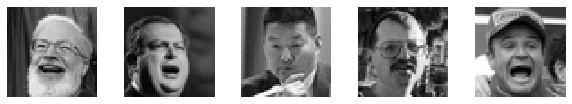

In [43]:
show_random_from_list(false_negatives,amount=5)

next cell just adds a result to my csv for this model.

In [87]:
# document results for my csv
now_time_date = datetime.datetime.now()
curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
res_line=["tested on all samples,no split","Pretrained \n cv2.CascadeClassifier(haarcascade_frontalface_default.xml)",curr_time_date,
          "-","-","-"]

false_negatives= []
timings=[]
pos_correct=0
for image_path in os.listdir(Pos_Dir):
    pos_image_path= Pos_Dir + '\\' + image_path
    pixels = cv2.imread(pos_image_path)
    
    start = int(timeit.time.time() * 1000)
    bboxes = classifier.detectMultiScale(pixels)
    end= int(timeit.time.time() * 1000)
    timings.append( end - start )
    
    if len(bboxes)==0 or len(bboxes)>1:
        false_negatives.append(pos_image_path)
    else:
        pos_correct+=1

avg_pred_time= sum(timings)/len(timings)

res_line.append(avg_pred_time)

total= len(os.listdir(Neg_Dir)) + len(os.listdir(Pos_Dir))
total_correct= len(os.listdir(Neg_Dir)) + pos_correct
accuracy= total_correct * 100 / total

res_line.append(accuracy)

recall= pos_correct * 100 / len(os.listdir(Pos_Dir))
res_line.append(recall)
add_result(res_line)


In [116]:
#try to change scale factor and minNeighbors
for i in [3]:
    cv_model_scale_neighbors(1.02,i)
    cv_model_scale_neighbors(1.03,i)
    cv_model_scale_neighbors(1.04,i)
    

In [119]:
res=pd.read_csv(Results_File_Path)
res.describe()

,time_ms,accuracy,recall
count,26.000000,26.000000,26.000000
mean,2.545596,94.363289,89.247411
std,2.754181,7.041448,14.343173
min,0.276442,67.588141,35.176282
25%,0.861879,93.419471,86.838942
50%,1.023237,96.955128,94.431090
75%,2.950421,98.587740,98.297276
max,9.919872,99.479167,99.358974


In [137]:
res.tail(n=6)

,comment,model_comment,date_time,batch,learning_rate,epochs,time_ms,accuracy,recall
20,"tested on all samples,no split",Pretrained\n cv2.CascadeClassifier(haarcascade...,06/01/20 17:41:55,-,-,-,3.788061,99.479167,99.358974
21,"tested on all samples,no split",Pretrained\n cv2.CascadeClassifier(haarcascade...,06/01/20 17:42:05,-,-,-,2.962340,99.158654,98.477564
22,"tested on all samples,no split",Pretrained\n cv2.CascadeClassifier(haarcascade...,06/01/20 17:42:14,-,-,-,2.673478,98.958333,97.996795
23,"tested on all samples,no split",Pretrained\n cv2.CascadeClassifier(haarcascade...,06/01/20 17:42:27,-,-,-,3.740385,99.318910,99.198718
24,"tested on all samples,no split",Pretrained\n cv2.CascadeClassifier(haarcascade...,06/01/20 17:42:37,-,-,-,2.914663,99.358974,99.118590
25,"tested on all samples,no split",Pretrained\n cv2.CascadeClassifier(haarcascade...,06/01/20 17:42:46,-,-,-,2.579728,99.158654,98.557692


In [134]:
max_row = res['recall'].values.argmax()
res.iloc[max_row]['model_comment']

'Pretrained\n cv2.CascadeClassifier(haarcascade_frontalface_default.xml)\nscale_1.02 MinNeighbors_4'

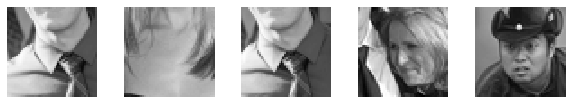

In [50]:
# see false predictions
false_prediction=[]
for image_path in os.listdir(Neg_Dir):
    neg_image_path= Neg_Dir + '\\' + image_path
    pixels = cv2.imread(neg_image_path)
    bboxes = classifier.detectMultiScale(pixels,1.02,4)

    if len(bboxes)!=0:
        false_prediction.append(neg_image_path)


for image_path in os.listdir(Pos_Dir):
    pos_image_path= Pos_Dir + '\\' + image_path
    pixels = cv2.imread(pos_image_path)
    bboxes = classifier.detectMultiScale(pixels,1.02,4)
    if len(bboxes)==0:
        false_prediction.append(pos_image_path)


show_random_from_list(false_prediction,amount=5)

In [51]:
false_prediction

['data\\negative\\000064.jpg_0_3431205__negative_3.png',
 'data\\negative\\000104.jpg_0_3431245__negative_2.png',
 'data\\negative\\000104.jpg_0_3431245__negative_8.png',
 'data\\negative\\000104.jpg_0_3431245__negative_9.png',
 'data\\negative\\000191.jpg_0_3431332__negative_2.png',
 'data\\aligned\\Roy_Halladay_0001.png',
 'data\\aligned\\Scott_Verplank_0001.png',
 'data\\aligned\\Shingo_Katayama_0001.png',
 'data\\aligned\\Sylvia_Plachy_0001.png',
 'data\\aligned\\Tara_Kirk_0001.png',
 'data\\aligned\\Thomas_Birmingham_0002.png']

In [66]:
       
# def load_pkl(path):
#     with open('filename.pickle', 'rb') as handle:
#         b = pickle.load(handle)


checking mtcnn model

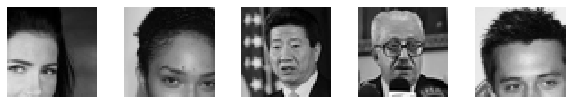

In [78]:
test_mcnn(0.5)

In [ ]:
#crashed my PC with overload :(
# all_paths= os.listdir(Pos_Dir) + os.listdir(Neg_Dir)
# falses= set(all_paths)
# for scale in [0.6,0.65,0.90,0.95,1,1.02,1.1,1.2]:
#     tmp=set()
#     wrongs= test_mcnn(scale)
#     if wrongs!=None and len(wrongs)>0:
#         tmp.update(wrongs)
#         print("updating")
#         falses= falses.intersection(tmp)
#     print(scale,end=' ')
# show_random_from_list(falses,amount=5)

updating
0.6 updating
0.65 updating
0.9 updating
0.95 

In [65]:
res= pd.read_csv(Results_File_Path)
res.tail(n=4)

,comment,model_comment,date_time,batch,learning_rate,epochs,time_ms,accuracy,recall
30,"tested on all samples,no split",Pretrained\n mtcnn_scale_0.6,6/2/2020 16:32,-,-,-,15.483574,99.358974,99.599359
31,"tested on all samples,no split",Pretrained\n mtcnn_scale_0.65,6/2/2020 16:33,-,-,-,23.516827,99.158654,99.839744
32,"tested on all samples,no split",Pretrained\n mtcnn_scale_0.9,6/2/2020 16:34,-,-,-,49.520032,98.677885,99.919872
33,"tested on all samples,no split",Pretrained\n mtcnn_scale_0.95,6/2/2020 16:36,-,-,-,83.993590,98.277244,100.000000


In [70]:
with open(Wrong_Dir+'//'+'mtcnn_scale_0.6','rb') as handle:
    w_mtcnn=set(pkl.load(handle))

with open(Wrong_Dir+'//'+'cv2_CascadeClassifier','rb') as handle:
    cascade=set(pkl.load(handle))


In [72]:
res=w_mtcnn.intersection(cascade)
res

#no intersection between wrong predictions

set()

checking cvlib

In [85]:
wrong=['data\\negative\\000064.jpg_0_3431205__negative_3.png',
 'data\\negative\\000104.jpg_0_3431245__negative_2.png',
 'data\\negative\\000104.jpg_0_3431245__negative_8.png',
 'data\\negative\\000104.jpg_0_3431245__negative_9.png',
 'data\\negative\\000191.jpg_0_3431332__negative_2.png',
 'data\\aligned\\Roy_Halladay_0001.png',
 'data\\aligned\\Scott_Verplank_0001.png',
 'data\\aligned\\Shingo_Katayama_0001.png',
 'data\\aligned\\Sylvia_Plachy_0001.png',
 'data\\aligned\\Tara_Kirk_0001.png',
 'data\\aligned\\Thomas_Birmingham_0002.png']

In [136]:
path=wrong[1]
image = PIL.Image.open(path)
image = image.convert('RGB')
pixels = np.asarray(image)
faces, confidences = cvlib.detect_face(pixels)

In [137]:
print(faces,confidences)

[] []


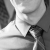

In [138]:
image

In [139]:
def test_cvlib(threshold=0.5):
    now_time_date = datetime.datetime.now()
    #model=mtcnn.MTCNN(scale_factor=scale)
    model_name= f'cvlib_threshold_{threshold}'
    curr_time_date= str(now_time_date.strftime("%x") + ' ' + now_time_date.strftime("%X"))
    res_line=["tested on all samples,no split",
              f'Pretrained\n {model_name}',
              curr_time_date, "-","-","-"]     

    timings=[]
    false_predictions=[]
    pos_correct=0  
    neg_correct=0

    for image_path in os.listdir(Neg_Dir):
        neg_image_path= Neg_Dir + '\\' + image_path

        image = PIL.Image.open(neg_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        faces, confidences = cvlib.detect_face(pixels,threshold=threshold)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)!=0:
            false_predictions.append(neg_image_path)
        else:
            neg_correct+=1    

    for image_path in os.listdir(Pos_Dir):
        pos_image_path= Pos_Dir + '\\' + image_path

        image = PIL.Image.open(pos_image_path)
        image = image.convert('RGB')
        pixels = np.asarray(image)

        start = int(timeit.time.time() * 1000)
        faces, confidences = cvlib.detect_face(pixels,threshold=threshold)
        end= int(timeit.time.time() * 1000)
        timings.append( end - start )
        if len(faces)==0:
            false_predictions.append(pos_image_path)
        else:
            pos_correct+=1
        
        
    append_stats(res_line, timings, Neg_Dir, Pos_Dir, neg_correct, pos_correct )
    add_result(res_line)

    save_Falses(Wrong_Dir,model_name,false_predictions)

    #return list(false_predictions)
    #show_random_from_list(false_predictions,amount=5)    

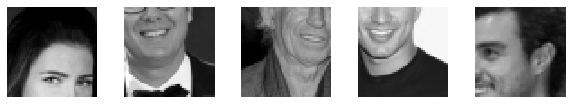

In [140]:
test_cvlib()

In [150]:
# based on https://github.com/experiencor/keras-yolo3
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
 
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model
 
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
        
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
    
	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
                
	def reset(self):
		self.offset = 0
        
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [151]:
model.summary()

Model: "model_185"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_185 (InputLayer)          (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_185[0][0]                  
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
__________________________________________________________________________________________

In [157]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = np.expand_dims(image, 0)
    return image, width, height
 
# load yolov3 model
model = load_model(Models_Dir +'//'+ 'yoloV3.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'Rudolf_Schuster_0001.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print(len(yhat))

3


testing yoloV3 on my dataset
  

25 50 75 100 125 150 175 200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 650 675 700 725 750 775 800 825 850 875 900 925 950 975 1000 1025 1050 1075 1100 1125 1150 1175 1200 1225 1250 1275 1300 1325 1350 1375 1400 1425 1450 1475 1500 1525 1550 1575 1600 1625 1650 1675 1700 1725 1750 1775 1800 1825 1850 1875 1900 1925 1950 1975 2000 2025 2050 2075 2100 2125 2150 2175 2200 2225 2250 2275 2300 2325 2350 2375 2400 2425 2450 2475 

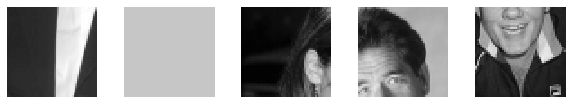

In [164]:
test_YOLOv3()

In [173]:
# with open(Wrong_Dir + '//' + 'YOLOv3','rb') as handle:
#     misPredictions= pkl.load(handle)
# print(misPredictions)
res=pd.read_csv(Results_File_Path)
res.tail(n=1)

,comment,model_comment,date_time,batch,learning_rate,epochs,time_ms,accuracy,recall
40,"tested on all samples,no split",Pretrained\n YOLOv3,06/02/20 21:43:08,-,-,-,1475.455128,50.0,100.0


In [215]:
res=pd.read_csv(Results_File_Path)
champs= res.iloc[[24,30,36,40],:]
champs.head()

,comment,model_comment,date_time,batch,learning_rate,epochs,time_ms,accuracy,recall
24,"tested on all samples,no split",Pretrained\n cv2.CascadeClassifier(haarcascade...,6/1/2020 17:42,-,-,-,2.914663,99.358974,99.118590
30,"tested on all samples,no split",Pretrained\n mtcnn_scale_0.6,6/2/2020 16:32,-,-,-,15.483574,99.358974,99.599359
36,"tested on all samples,no split",Pretrained\n cvlib_threshold_0.5,06/02/20 18:34:38,-,-,-,51.439503,91.506410,95.352564
40,"tested on all samples,no split",Pretrained\n YOLOv3,06/02/20 21:43:08,-,-,-,1475.455128,50.000000,100.000000


In [216]:
champs.loc[24]['model_comment']

'Pretrained\n cv2.CascadeClassifier(haarcascade_frontalface_default.xml)\nscale_1.03 MinNeighbors_3'

In [225]:
c=champs.loc[:,['time_ms','accuracy','recall']]
res= []
for i in range(0,len(c)):
    res.append(list(c.iloc[i,:]))
    for x in range(0,len(res[i])):
        res[i][x]=round(res[i][x],2)
res

[[2.91, 99.36, 99.12],
 [15.48, 99.36, 99.6],
 [51.44, 91.51, 95.35],
 [1475.46, 50.0, 100.0]]

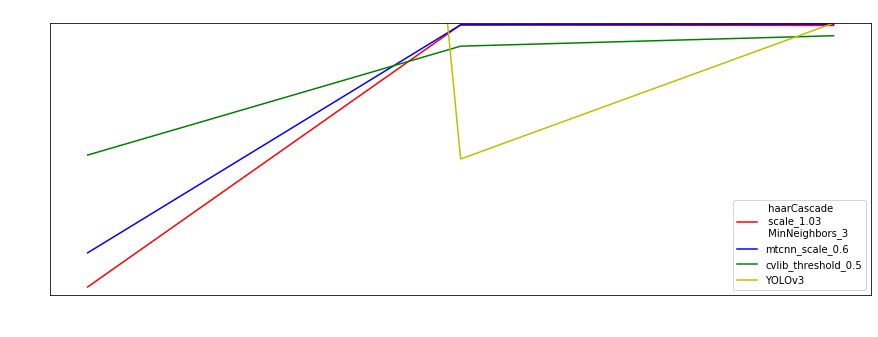

In [260]:
categories= ['time_ms','accuracy','recall']
colors= ['r','b','g','y']
models=[' haarCascade\n scale_1.03\n MinNeighbors_3', 'mtcnn_scale_0.6','cvlib_threshold_0.5','YOLOv3']

plt.figure(figsize=(50,5))
ax_2 = plt.subplot(133)
ax_2.set_ylim([0, 100])
for i in range(0,len(colors)):   
    # print(categories, res[i], colors[i],models[i])
    
    plt.plot(categories, res[i], color=colors[i], label=models[i],)

ax_2.set_title('Pretrained models',c='w')
ax_2.set_ylabel('Values', fontsize=12,c='w')
ax_2.set_xlabel('Categories', fontsize=12,c='w')
ax_2.tick_params(axis='y', colors='w')
ax_2.tick_params(axis='x', colors='w')


plt.legend(loc='lower right')
#plt.tight_layout()
# plt.savefig('images/spectral_centroids-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()

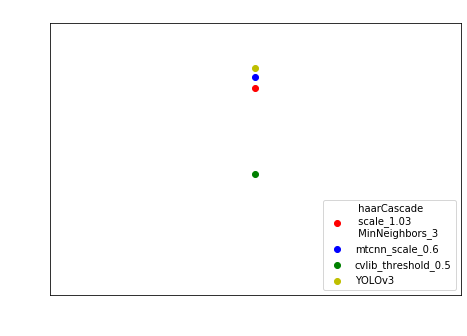

In [277]:
categories= ['recall'] # ,'accuracy','recall'
colors= ['r','b','g','y']
models=[' haarCascade\n scale_1.03\n MinNeighbors_3', 'mtcnn_scale_0.6','cvlib_threshold_0.5','YOLOv3']  

plt.figure(figsize=(25,5))
ax_2 = plt.subplot(133)
ax_2.set_ylim([90, 102])
for i in range(0,len(colors)):   
    # print(categories, res[i], colors[i],models[i])
    
    plt.scatter(categories, res[i][2], color=colors[i], label=models[i])

ax_2.set_title('Pretrained models',c='w')
ax_2.set_ylabel('Recall  %', fontsize=12,c='w')
ax_2.set_xlabel('Category', fontsize=12,c='w')
ax_2.tick_params(axis='y', colors='w')
ax_2.tick_params(axis='x', colors='w')


plt.legend(loc='lower right')
#plt.tight_layout()
# plt.savefig('images/spectral_centroids-Pos_vs_Neg.jpeg', bbox_inches='tight')
plt.show()

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.73233938217163
person 97.0426619052887


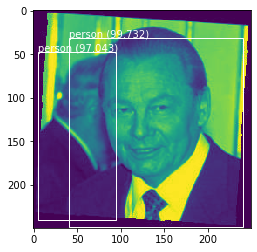

In [155]:
# based on https://github.com/experiencor/keras-yolo3
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
        
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
            
		return self.label
    
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
            
		return self.score
    
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
    
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
        
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
                    
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()
    
# load yolov3 model
model = load_model('model.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'Rudolf_Schuster_0001.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["person"]
# , "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
# 	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
# 	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
# 	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
# 	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
# 	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
# 	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
# 	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
# 	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
# 	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)